In [1]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [4]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.0853, 0.2793),

])

In [26]:
val_dataset = torchvision.datasets.DatasetFolder("../Data/Pneumonia/Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [6]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
list(temp_model.children())[:-2] 

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [55]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)        
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    
    def forward(self, data):
        
        feature_map = self.feature_map(data)
        
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        pred = self.model.fc(avg_pool_output_flattened)
        
        return pred, feature_map

In [54]:
model = PneumoniaModel.load_from_checkpoint("../Data/Pneumonia/weights/weights_1.ckpt", strict=False)
model = model.cpu()
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\mstew\anaconda3\Notebooks\Data\Pneumonia\weights\weights_1.ckpt`


In [53]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape
    
    features = features.reshape((c, h*w))    
   
    weight_params = list(model.model.fc.parameters())[0] 
        
    weight = weight_params[0].detach()
    print(weight.shape)
   
    cam = torch.matmul(weight, features)
    print(features.shape)
    
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)


In [52]:
def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]
    
    
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(img, cmap="bone")
    
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [50]:
img = val_dataset[-6][0]  # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 56])


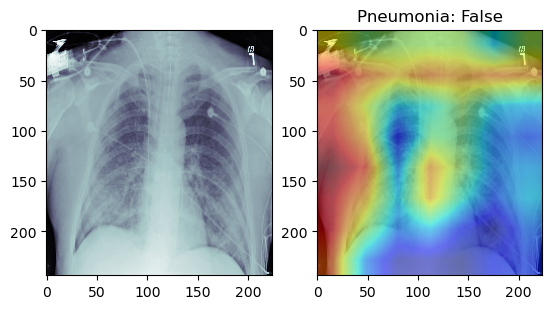

In [51]:
visualize(img, activation_map, pred)